# Models

Build models to see how much each feature contributes to productivity

- Models
    - LinearRegression
    - ExplainableBoostingRegressor
- Features
    - Education
    - Population
    - R&D Expenditure
    
## Feature Engineering

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [31]:
# See: ../src/data/make_dataset.py
df = pd.read_csv('../data/interim/dataset.csv')
print(df['year'].unique())
df.head()

[2010 2011 2012 2013 2014 2015 2016 2017]


,year,GEO,per_hour_worked,per_employee,education,population,rd_expenditure
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06
1,2011,Belgium,35.1,50593.5,47.857143,11000638,2.17
2,2012,Belgium,36.2,52178.2,48.242857,11075889,2.28
3,2013,Belgium,37.2,53452.5,49.242857,11137974,2.33
4,2014,Belgium,37.6,53965.2,50.285714,11180840,2.37


## Add Trends

There are several ways to capture trends.

- Move data to n years (`shift`)
- Take the mean of n years
- ...

In [32]:
features = ['education', 'population', 'rd_expenditure']
shift_range = [1, 2]

def add_trends(df):
    for feature in features:
        for shift in shift_range:
            df[f'{feature}_shift_{shift}'] = df.sort_values('year').groupby(['GEO'])[feature].shift(shift)
            df[f'{feature}_diff_{shift}'] = df[feature] - df[f'{feature}_shift_{shift}']

add_trends(df)
df.head()

,year,GEO,per_hour_worked,per_employee,education,population,rd_expenditure,education_shift_1,education_diff_1,education_shift_2,education_diff_2,population_shift_1,population_diff_1,population_shift_2,population_diff_2,rd_expenditure_shift_1,rd_expenditure_diff_1,rd_expenditure_shift_2,rd_expenditure_diff_2
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,Belgium,35.1,50593.5,47.857143,11000638,2.17,48.457143,-0.600000,NaN,NaN,10839905.0,160733.0,NaN,NaN,2.06,0.11,NaN,NaN
2,2012,Belgium,36.2,52178.2,48.242857,11075889,2.28,47.857143,0.385714,48.457143,-0.214286,11000638.0,75251.0,10839905.0,235984.0,2.17,0.11,2.06,0.22
3,2013,Belgium,37.2,53452.5,49.242857,11137974,2.33,48.242857,1.000000,47.857143,1.385714,11075889.0,62085.0,11000638.0,137336.0,2.28,0.05,2.17,0.16
4,2014,Belgium,37.6,53965.2,50.285714,11180840,2.37,49.242857,1.042857,48.242857,2.042857,11137974.0,42866.0,11075889.0,104951.0,2.33,0.04,2.28,0.09


## Add Aggregation Features

In [37]:
agg_params = {}
for feature in features:
    for shift in shift_range:
        agg_params[f'{feature}_shift_{shift}_mean'] = (f'{feature}_shift_{shift}', 'mean')

agg = df.groupby('year').agg(**agg_params).reset_index()
df = df.merge(agg, on='year')
df.head()

,year,GEO,per_hour_worked,per_employee,education,population,rd_expenditure,education_shift_1,education_diff_1,education_shift_2,...,population_shift_1_mean_x,population_shift_2_mean_x,rd_expenditure_shift_1_mean_x,rd_expenditure_shift_2_mean_x,education_shift_1_mean_y,education_shift_2_mean_y,population_shift_1_mean_y,population_shift_2_mean_y,rd_expenditure_shift_1_mean_y,rd_expenditure_shift_2_mean_y
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Bulgaria,3.2,5287.3,45.091667,7421766,0.57,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,Czechia,8.5,14802.0,55.166667,10462088,1.34,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,Denmark,35.2,49180.4,72.966667,5534738,2.92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,Germany,26.2,35409.2,57.473333,81802257,2.73,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
for feature in features:
    for shift in shift_range:
        df[f'{feature}_shift_{shift}_mean_diff'] = df[f'{feature}_shift_{shift}'] - df[f'{feature}_shift_{shift}_mean']
df.head()

,year,GEO,per_hour_worked,per_employee,education,population,rd_expenditure,education_shift_1,education_diff_1,education_shift_2,...,population_shift_1_mean,population_shift_2_mean,rd_expenditure_shift_1_mean,rd_expenditure_shift_2_mean,education_shift_1_mean_diff,education_shift_2_mean_diff,population_shift_1_mean_diff,population_shift_2_mean_diff,rd_expenditure_shift_1_mean_diff,rd_expenditure_shift_2_mean_diff
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Bulgaria,3.2,5287.3,45.091667,7421766,0.57,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,Czechia,8.5,14802.0,55.166667,10462088,1.34,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,Denmark,35.2,49180.4,72.966667,5534738,2.92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,Germany,26.2,35409.2,57.473333,81802257,2.73,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Scale Features

In [6]:
columns_to_fit = [
    'education_shift_1',
    'education_shift_1_mean_diff',
    'education_diff_1',
    'education_shift_2',
    'education_shift_2_mean_diff',
    'education_diff_2',
    'population_shift_1',
    'population_shift_1_mean_diff',
    'population_diff_1',
    'population_shift_2',
    'population_shift_2_mean_diff',
    'population_diff_2',
    'rd_expenditure_shift_1',
    'rd_expenditure_shift_1_mean_diff',
    'rd_expenditure_diff_1',
    'rd_expenditure_shift_2',
    'rd_expenditure_shift_2_mean_diff',
    'rd_expenditure_diff_2',
]

def scale(df):
    for column in columns_to_fit:
        scaler = MinMaxScaler()
        df[column] = scaler.fit_transform(df[[column]])

scale(df)
df.head()

,year,GEO,per_hour_worked,per_employee,education,population,rd_expenditure,education_shift_1,education_diff_1,education_shift_2,...,population_shift_1_mean,population_shift_2_mean,rd_expenditure_shift_1_mean,rd_expenditure_shift_2_mean,education_shift_1_mean_diff,education_shift_2_mean_diff,population_shift_1_mean_diff,population_shift_2_mean_diff,rd_expenditure_shift_1_mean_diff,rd_expenditure_shift_2_mean_diff
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Bulgaria,3.2,5287.3,45.091667,7421766,0.57,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,Czechia,8.5,14802.0,55.166667,10462088,1.34,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,Denmark,35.2,49180.4,72.966667,5534738,2.92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,Germany,26.2,35409.2,57.473333,81802257,2.73,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Split Dataset

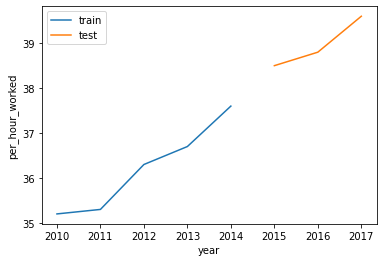

train shape: (170, 31), test shape: (102, 31)


In [7]:
train_size = 0.7

years = df['year'].unique()
years = sorted(years)
pivot = int(len(years) * train_size)
train_index = years[:pivot]
test_index = years[pivot:]

train_df = df[df['year'].isin(train_index)]
test_df = df[df['year'].isin(test_index)]

train_temp = train_df[train_df['GEO'] == 'Denmark']
test_temp = test_df[test_df['GEO'] == 'Denmark']
sns.lineplot(data=train_temp, x='year', y='per_hour_worked', label='train')
sns.lineplot(data=test_temp, x='year', y='per_hour_worked', label='test')
plt.show()

print(f'train shape: {train_df.shape}, test shape: {test_df.shape}')

In [8]:
# train_df = pd.read_csv('../data/interim/train.csv')
# test_df = pd.read_csv('../data/interim/test.csv')
# train_df.head()

## Visualization for Train Dataset

- Correlation
- jointplot
- pairplot

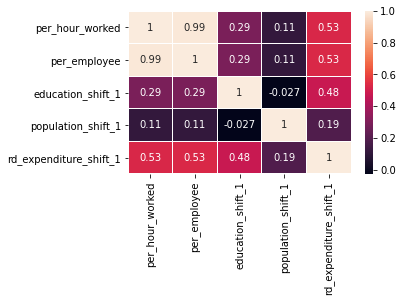

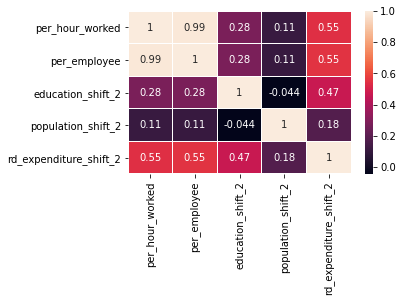

In [9]:
features = [
    ['education_shift_1', 'population_shift_1', 'rd_expenditure_shift_1'],
    ['education_shift_2', 'population_shift_2', 'rd_expenditure_shift_2'],
]

for fs in features:
    corr = train_df[
        ['per_hour_worked', 'per_employee'] + fs
    ].corr()
    plt.figure(figsize=(5,3))
    sns.heatmap(corr, annot=True, linewidths=0.2)
    plt.show()

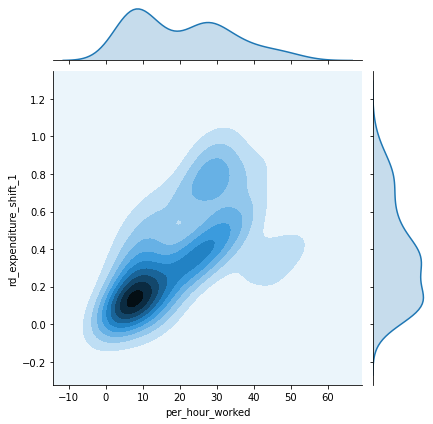

In [10]:
sns.jointplot(data=train_df, x='per_hour_worked', y='rd_expenditure_shift_1', kind='kde')

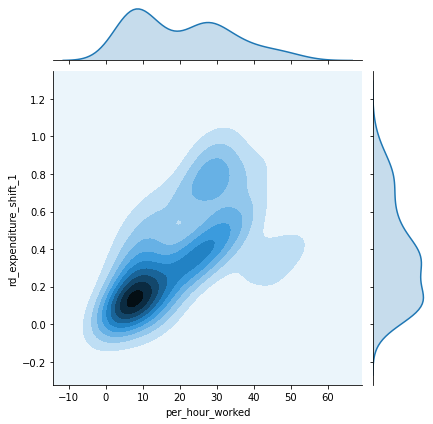

In [11]:
sns.jointplot(data=train_df, x='per_hour_worked', y='rd_expenditure_shift_1', kind='kde')

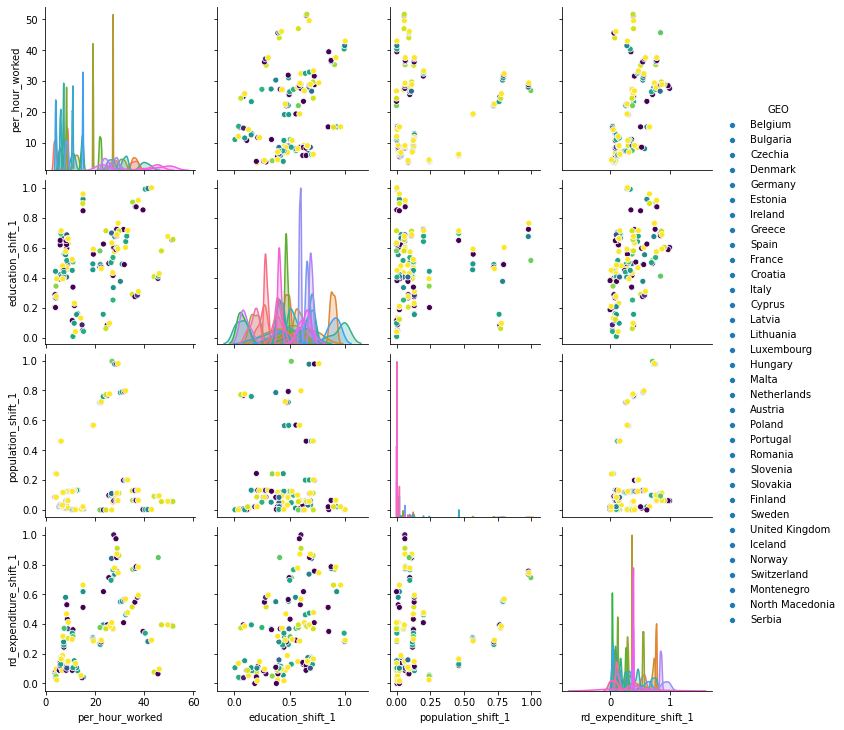

In [12]:
sns.pairplot(train_df[[
    'GEO',
    'per_hour_worked',
    'education_shift_1',
    'population_shift_1',
    'rd_expenditure_shift_1',
]], hue='GEO')

# Train Models

Train models to predict compensation (productivity) using past data.

## LinearRegression

$$
y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$

,features,error,train?
4,"education_shift_1, education_shift_1_mean_diff...",10.332592,train
5,"education_shift_1, education_shift_1_mean_diff...",10.576585,test
0,"education_shift_1, population_shift_1, rd_expe...",10.982855,train
2,"education_shift_2, population_shift_2, rd_expe...",11.015299,train
1,"education_shift_1, population_shift_1, rd_expe...",11.151604,test
3,"education_shift_2, population_shift_2, rd_expe...",11.313851,test


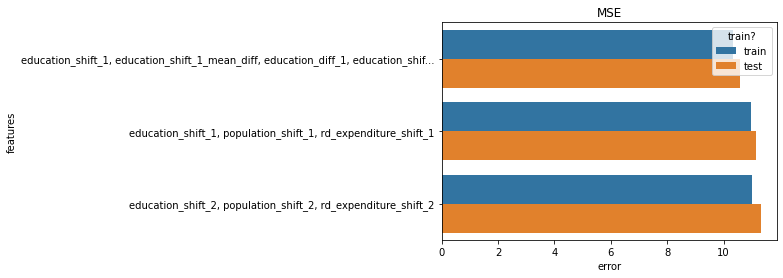

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fit(features):
    train_temp = train_df[features + ['per_hour_worked']].dropna()
    test_temp = test_df[features + ['per_hour_worked']].dropna()
    x_train, y_train = train_temp[features], train_temp[['per_hour_worked']]
    x_test, y_test = test_temp[features], test_temp[['per_hour_worked']]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    train_error = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))
    test_error = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    return train_error, test_error

features = [
    ['education_shift_1', 'population_shift_1', 'rd_expenditure_shift_1'],
    ['education_shift_2', 'population_shift_2', 'rd_expenditure_shift_2'],
    columns_to_fit
]

rows = []
for fs in features:
    train_error, test_error = fit(fs)
    feature_name = ', '.join(fs)
    if len(feature_name) > 80:
        feature_name = feature_name[:80] + '...'
    rows.append({
        'features': feature_name,
        'error': train_error,
        'train?': 'train'
    })
    rows.append({
        'features': feature_name,
        'error': test_error,
        'train?': 'test'
    })
    
result = pd.DataFrame(rows).sort_values(by='error')
display(result)

sns.barplot(data=result, x='error', y='features', hue='train?').set_title('MSE')
plt.show()

In [14]:
train_temp = train_df[columns_to_fit + ['per_hour_worked']].dropna()
test_temp = test_df[columns_to_fit + ['per_hour_worked']].dropna()
x_train, y_train = train_temp[columns_to_fit], train_temp[['per_hour_worked']]
x_test, y_test = test_temp[columns_to_fit], test_temp[['per_hour_worked']]

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## LightGBM

This is a kind of gradient boosting tree.

GitHub: https://github.com/microsoft/LightGBM

In [15]:
import shap
shap.initjs()

In [16]:
from lightgbm import LGBMRegressor

train_temp = train_df[columns_to_fit + ['per_hour_worked']].dropna()
test_temp = test_df[columns_to_fit + ['per_hour_worked']].dropna()
x_train, y_train = train_temp[columns_to_fit], train_temp[['per_hour_worked']]
x_test, y_test = test_temp[columns_to_fit], test_temp[['per_hour_worked']]

gbm = LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Tune LightGBM using Optuna

Optuna employs a Bayesian optimization algorithm called Tree-structured Parzen Estimator.

Paper: https://arxiv.org/abs/1907.10902
GitHub: https://github.com/optuna/optuna

In [17]:
import lightgbm as lgb
import optuna

def objective(trial):
    param = {
        "objective": "regression",
        "metric": "l2",
        "verbosity": 0,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
    }

    dtrain = lgb.Dataset(x_train, label=y_train)
    gbm = lgb.train(param, dtrain)
    error = np.sqrt(mean_squared_error(y_test, gbm.predict(x_test)))
    return error

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 5.404294938569872
  Params: 
 lambda_l1: 0.012535253537712735
 lambda_l2: 0.0013580596434003185
 num_leaves: 162
 feature_fraction: 0.5101981984443186
 bagging_fraction: 0.7503109574060394
 bagging_freq: 2
 min_child_samples: 8


In [18]:
dtrain = lgb.Dataset(x_train, label=y_train)
params = trial.params
params['objective'] = 'regression'
tuned_gbm = lgb.train(params, dtrain)
error = np.sqrt(mean_squared_error(y_test, tuned_gbm.predict(x_test)))
error

5.404294938569872

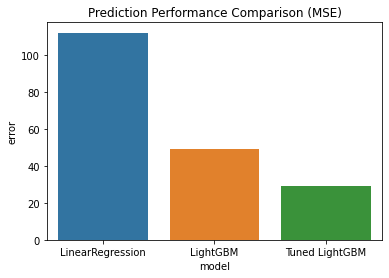

In [19]:
rows = []
rows.append({
    'model': 'LinearRegression',
    'error': mean_squared_error(y_test, lr.predict(x_test)),
})
rows.append({
    'model': 'LightGBM',
    'error': mean_squared_error(y_test, gbm.predict(x_test)),
})
rows.append({
    'model': 'Tuned LightGBM',
    'error': mean_squared_error(y_test, tuned_gbm.predict(x_test)),
})
result = pd.DataFrame(rows).sort_values('error', ascending=False)
sns.barplot(data=result, x='model', y='error').set_title('Prediction Performance Comparison (MSE)')
plt.show()

# Visualize Predictions

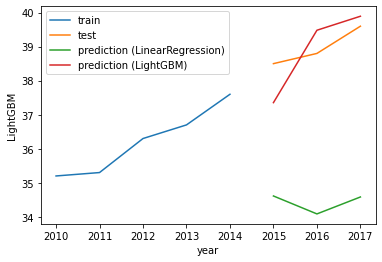

In [20]:
country = 'Denmark'
train_temp = train_df[train_df['GEO'] == country]
test_temp = test_df[columns_to_fit + ['per_hour_worked', 'year', 'GEO']].dropna()
test_temp = test_temp[test_temp['GEO'] == country]
x_test, y_test = test_temp[columns_to_fit], test_temp[['per_hour_worked']]

test_temp['LinearRegression'] = lr.predict(x_test)
test_temp['LightGBM'] = tuned_gbm.predict(x_test)

sns.lineplot(data=train_temp, x='year', y='per_hour_worked', label='train')
sns.lineplot(data=test_temp, x='year', y='per_hour_worked', label='test')
sns.lineplot(data=test_temp, x='year', y='LinearRegression', label='prediction (LinearRegression)')
sns.lineplot(data=test_temp, x='year', y='LightGBM', label='prediction (LightGBM)')
plt.show()

# Visualize Feature Importance

- Coefficients (LinearRegression)
- Shap (LightBGM)
  - Paper: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions
  - GitHub: https://github.com/slundberg/shap
- InterpretML (ExplainableBoostingRegressor)
  - GitHub: https://github.com/interpretml/interpret

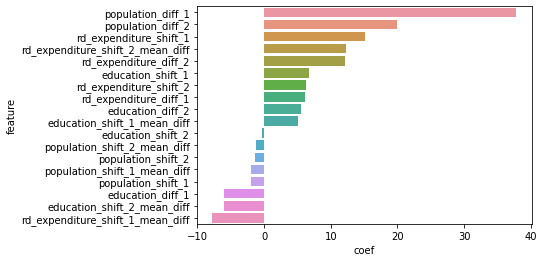

In [21]:
train_temp = train_df[columns_to_fit + ['per_hour_worked']].dropna()
test_temp = test_df[columns_to_fit + ['per_hour_worked']].dropna()
x_train, y_train = train_temp[columns_to_fit], train_temp[['per_hour_worked']]
x_test, y_test = test_temp[columns_to_fit], test_temp[['per_hour_worked']]

lr = LinearRegression()
lr.fit(x_train, y_train)

result = pd.DataFrame({
    'feature': columns_to_fit,
    'coef': lr.coef_[0]
}).sort_values(by=['coef'], ascending=False)
sns.barplot(data=result, y='feature', x='coef')

In [22]:
explainer = shap.TreeExplainer(tuned_gbm)
shap_values = explainer.shap_values(x_test)

shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])

/Users/kentaro-takiguchi/.local/share/virtualenvs/eu-productivity-Iv3gjvJ9/lib/python3.7/site-packages/shap/explainers/tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



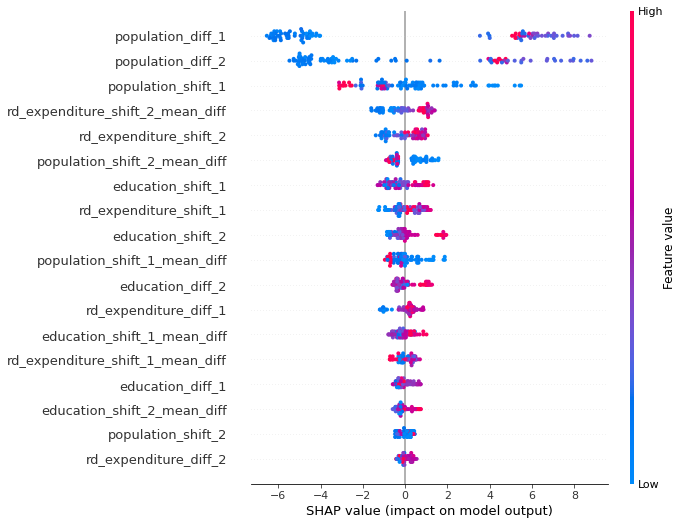

In [23]:
shap.summary_plot(shap_values, x_test)

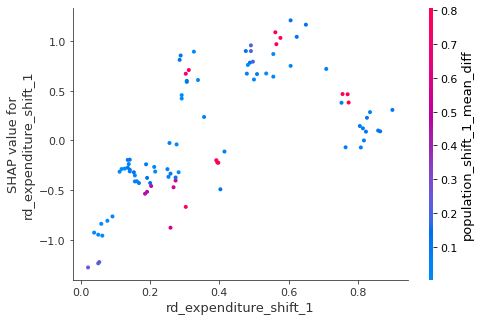

In [24]:
shap.dependence_plot('rd_expenditure_shift_1', shap_values, x_test)

## ExplainableBoostingRegressor (from InterpretML)

EBM is a generalized additive model formalized as follows.

$$
g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ij}(x_i,x_j)
$$

EBM learns the best feature function $f_j$ for each feature to show how each feature contributes to the model's prediction for the problem. EBM can also automatically detect and include pairwise interaction terms.

Paper: https://arxiv.org/pdf/1909.09223.pdf

### Global Explanation

In [25]:
from sklearn.model_selection import train_test_split
import interpret
from interpret.glassbox import ExplainableBoostingRegressor

train_temp = train_df[columns_to_fit + ['per_hour_worked']].dropna()
test_temp = test_df[columns_to_fit + ['per_hour_worked']].dropna()
x_train, y_train = train_temp[columns_to_fit], train_temp[['per_hour_worked']]
x_test, y_test = test_temp[columns_to_fit], test_temp[['per_hour_worked']]

ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(x_train, y_train)

ebm_global = ebm.explain_global(name='EBM')
interpret.show(ebm_global)

<!-- http://127.0.0.1:7151/4896646608/ -->

### Local Explanation

In [26]:
ebm_local = ebm.explain_local(x_test[:5], y_test[:5], name='EBM')
interpret.show(ebm_local)

<!-- http://127.0.0.1:7151/4931139472/ -->

In [27]:
from interpret.glassbox import LinearRegression
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(x_test, y_test, name='Linear Regression')
interpret.show(ebm_perf)

<!-- http://127.0.0.1:7151/4598737168/ -->